# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [7]:
#setwd("/Users/ribalet/Documents/DATA/Codes/ssPopModel")
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(seewave)
df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
library(DEoptim)
library(cmaes) 
        
        resol <- 10
		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Warning message:
"package 'seewave' was built under R version 3.5.2"Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich



- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [8]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [9]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]), resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


# 1. Original model
---

## 1a. Load matrix model

In [10]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [11]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		resnorm <- opt$optim$bestval

Iteration: 10 bestvalit: 5.793381 bestmemit:    0.162124    0.019853    3.868959  402.252500
Iteration: 20 bestvalit: 5.316598 bestmemit:    0.121595    0.027117    3.749742  223.078975
Iteration: 30 bestvalit: 4.991960 bestmemit:    0.157141    0.034778    3.999861  240.909051
Iteration: 40 bestvalit: 4.979991 bestmemit:    0.165791    0.036348    4.141776  254.803377
Iteration: 50 bestvalit: 4.977271 bestmemit:    0.164988    0.036241    4.065342  253.465381
Iteration: 60 bestvalit: 4.974883 bestmemit:    0.163377    0.035661    4.043623  257.581638
Iteration: 70 bestvalit: 4.974883 bestmemit:    0.163377    0.035661    4.043623  257.581638
Iteration: 80 bestvalit: 4.974571 bestmemit:    0.164943    0.035732    4.052012  256.890919
Iteration: 90 bestvalit: 4.974271 bestmemit:    0.165856    0.035837    4.040310  256.126572
Iteration: 100 bestvalit: 4.973550 bestmemit:    0.165558    0.036170    4.063266  257.618506
Iteration: 110 bestvalit: 4.973550 bestmemit:    0.165558    0.036170

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [12]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.242299 bestmemit:    0.154731    0.028140    3.393435  310.236550
Iteration: 20 bestvalit: 0.232371 bestmemit:    0.188935    0.033910    3.781670  250.858326
Iteration: 30 bestvalit: 0.231277 bestmemit:    0.169373    0.029845    3.703294  251.684979
Iteration: 40 bestvalit: 0.230825 bestmemit:    0.169487    0.034024    3.975288  243.821656
Iteration: 50 bestvalit: 0.230143 bestmemit:    0.174006    0.033235    3.888811  255.970514
Iteration: 60 bestvalit: 0.229874 bestmemit:    0.170272    0.031624    3.885095  255.523903
Iteration: 70 bestvalit: 0.229855 bestmemit:    0.170272    0.031624    3.885823  255.523903
Iteration: 80 bestvalit: 0.229709 bestmemit:    0.171460    0.031859    3.894764  261.026884
Iteration: 90 bestvalit: 0.229709 bestmemit:    0.171460    0.031859    3.894764  261.026884
Iteration: 100 bestvalit: 0.229709 bestmemit:    0.171460    0.031859    3.894764  261.026884
Iteration: 110 bestvalit: 0.229709 bestmemit:    0.171460    0.031859

## 1c. Results

In [13]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2)))


[1] "daily growth rate= 0.73 - 0.72"


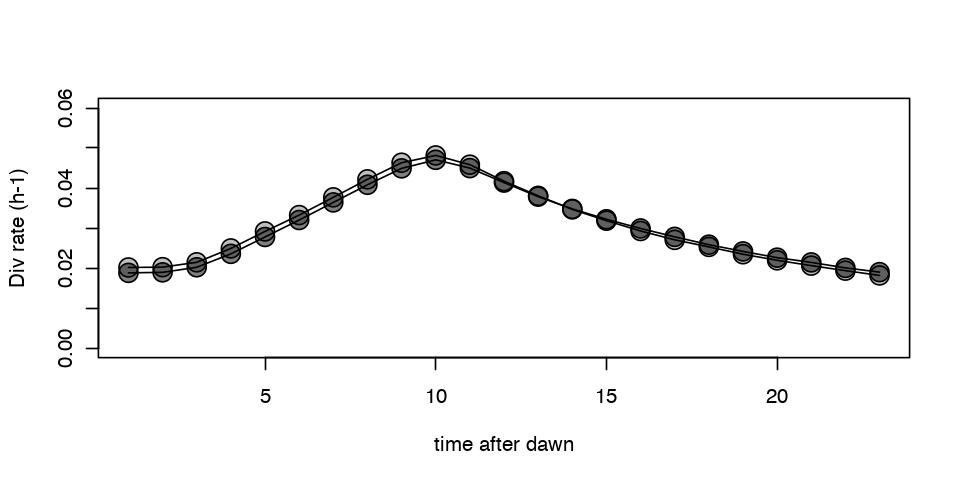

In [14]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

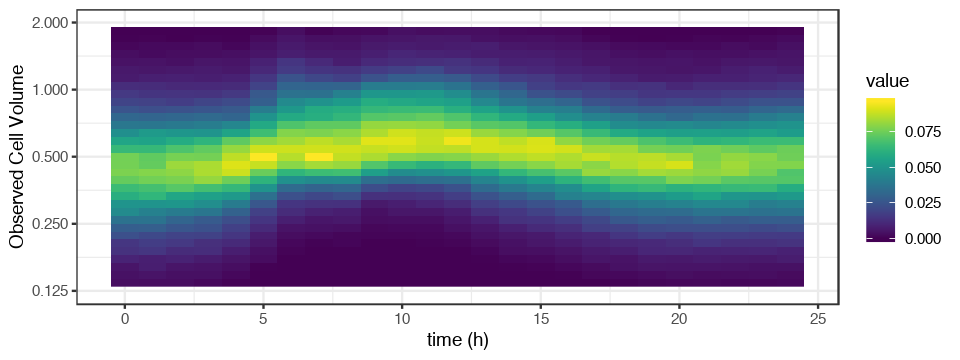

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

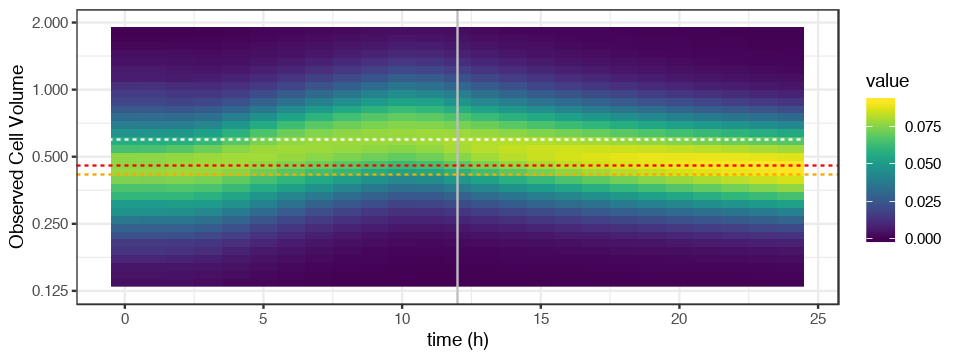

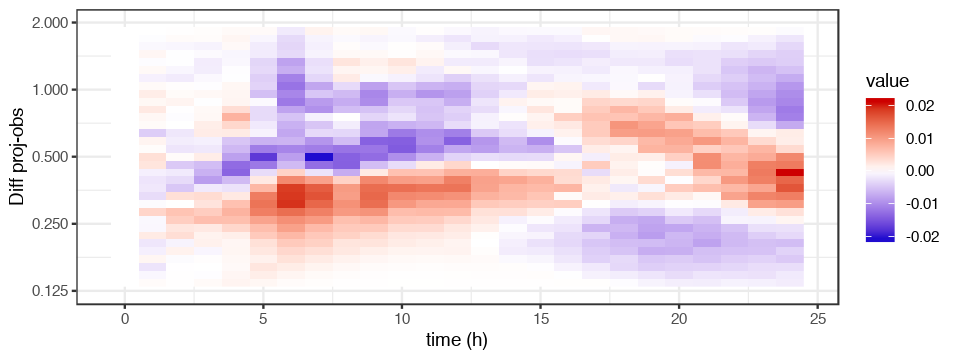

In [9]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj[,12] == max(Vproj[,12]))
f <- which(Vproj[,24] == max(Vproj[,24]))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Model with respioration, no cell division
---

To model ```respiration``` in the matrix model of Prochlorococcus, I had to make two major assumptions: 
- Carbon storage represents 30% of carbon fixed by photosynthesis (e.g., Zavreb et al. 2019)
- All carbon storage is consumed at night (ref TBD, but it has to be based on mass flux analysis)

These two assumptions would translate into a 30% reduction of carbon quotas from dusk to dawn (where dark respiration takes place).
A fun excercise. What is the expected reduction in cell diameter caused by respiration?

In [10]:
resp <- 30  # 30% change due to respiration
mass.at.dusk <- 50 # fg, Synecho carbon quotas
mass.at.dawn <- mass.at.dusk * (100-resp)/100
volume.at.dusk <- (0.001*mass.at.dusk/(0.216))^{1/0.860} # Menden-Deuer & Lessard 2000
volume.at.dawn <- (0.001*mass.at.dawn/(0.216))^{1/0.860} 
diam.at.dusk <- 2 * round((3/4*volume.at.dusk /pi)^{1/3},2) 
diam.at.dawn <- 2 * round((3/4*volume.at.dawn /pi)^{1/3},2) 
diff <- diam.at.dusk - diam.at.dawn

print(paste0(resp,'% reduction in a ',mass.at.dusk,' fg Prochlorococcus would translate to = '))
print(paste0(round(100*(volume.at.dusk - volume.at.dawn)/volume.at.dusk),'% reduction in cell volume (',round(volume.at.dusk - volume.at.dawn,3),' cubic microns)'))
print(paste0(round(100*(diam.at.dusk - diam.at.dawn)/diam.at.dusk),'% reduction in cell diameter (',diam.at.dusk - diam.at.dawn,' microns)'))

[1] "30% reduction in a 50 fg Prochlorococcus would translate to = "
[1] "34% reduction in cell volume (0.062 cubic microns)"
[1] "11% reduction in cell diameter (0.08 microns)"


## 2a. Load matrix model, respiration = reduction of 30% cell volume at night

In [15]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 7 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

### Optimization 
sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [16]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.709383 bestmemit:    0.078382    0.886771    0.040271  257.169762
Iteration: 20 bestvalit: 5.703136 bestmemit:    0.077082    0.566838    5.681422  260.595505
Iteration: 30 bestvalit: 5.700559 bestmemit:    0.076468    0.379422    1.321257  257.509998
Iteration: 40 bestvalit: 5.699696 bestmemit:    0.076625    0.791636   12.202194  260.043475
Iteration: 50 bestvalit: 5.699696 bestmemit:    0.076625    0.885501    5.507660  260.043475
Iteration: 60 bestvalit: 5.699405 bestmemit:    0.076607    0.937680    8.098120  260.129763
Iteration: 70 bestvalit: 5.699153 bestmemit:    0.076608    0.656536    9.518195  260.055115
Iteration: 80 bestvalit: 5.699027 bestmemit:    0.076611    0.751502    9.821485  259.886617
Iteration: 90 bestvalit: 5.698899 bestmemit:    0.076611    0.867766    8.349393  259.926995
Iteration: 100 bestvalit: 5.698899 bestmemit:    0.076610    0.190810   11.082886  259.948189


## 2b. Load matrix model, respiration = 30% cell growth

In [17]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

### Optimization 
sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [18]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		resnorm2. <- opt$optim$bestval

Iteration: 10 bestvalit: 6.320077 bestmemit:    0.107549    0.186595    2.958581  255.683340
Iteration: 20 bestvalit: 6.312896 bestmemit:    0.106105    0.504273    3.256281  257.414085
Iteration: 30 bestvalit: 6.311528 bestmemit:    0.107262    0.501846   13.103113  257.724818
Iteration: 40 bestvalit: 6.310842 bestmemit:    0.107225    0.127442   10.062334  260.020284
Iteration: 50 bestvalit: 6.310691 bestmemit:    0.107239    0.740423    4.562311  259.630058
Iteration: 60 bestvalit: 6.309875 bestmemit:    0.107248    0.649493    6.282758  259.670733
Iteration: 70 bestvalit: 6.309875 bestmemit:    0.107250    0.801294    1.549226  259.678448
Iteration: 80 bestvalit: 6.309875 bestmemit:    0.107248    0.479685    2.214594  259.645061
Iteration: 90 bestvalit: 6.309875 bestmemit:    0.107247    0.717905   10.491210  259.650417
Iteration: 100 bestvalit: 6.309875 bestmemit:    0.107250    0.657926    8.904336  259.655878
Iteration: 110 bestvalit: 6.309706 bestmemit:    0.107268    0.275598

## 2c. Results

In [19]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj2 <- Vproj2. <- V.hists
Nproj2 <- Nproj2. <- N.dist
mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2, resol=resol)
    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
	Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
	Vproj2[,hr+1] <- Vproj2[,hr+1]/sum(Vproj2[,hr+1]) # normalize distribution so sum = 1
	mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
					((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2., resol=resol)
  Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
	Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
	Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
	mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
					((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj2)
colnames(mu_N2) <- colnames(Vproj2)
Nproj2. <- colSums(Nproj2.)
colnames(mu_N2.) <- colnames(Vproj2.)

#############################
## Growth rate calculation ##
#############################
d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N2,2),"-",round(d.mu_N2.,2)))

[1] "daily growth rate= 0 - 0"


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

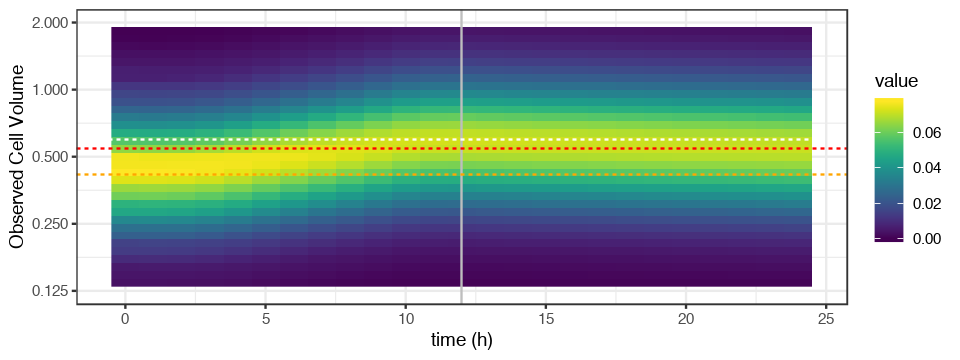

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

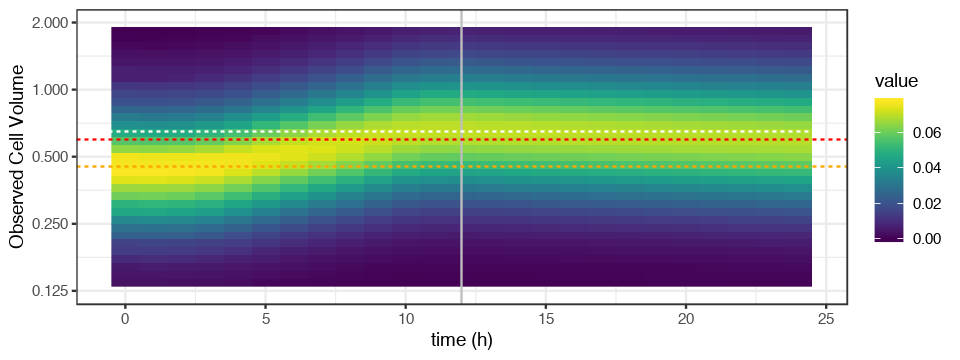

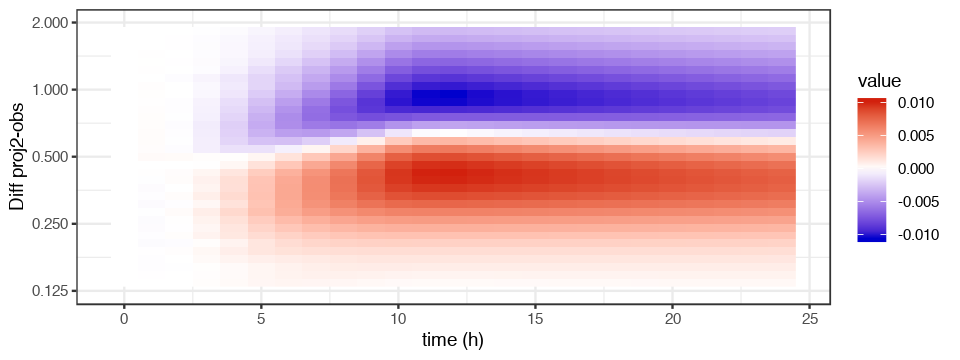

In [20]:
options(repr.plot.width=8, repr.plot.height=3)
i <- which(Vproj2[,12] == max(Vproj2[,12]))
f <- which(Vproj2[,24] == max(Vproj2[,24]))
ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + 
    scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

i <- which(Vproj2.[,12] == max(Vproj2.[,12]))
f <- which(Vproj2.[,24] == max(Vproj2.[,24]))
ggplot(melt(Vproj2.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + 
    scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj2-Vproj2.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj2-obs') + 
    scale_fill_gradient2(low='blue3',high='red3', midpoint=0)


# 3. Model with Respiration and cell division
---

## 3a. Load matrix model

In [21]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) rate of respiration is a function of photosynthetic rate (gamma function)
			# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [22]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		resnorm3 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.299169 bestmemit:    0.152422    0.034523    3.737803   93.442860
Iteration: 20 bestvalit: 4.854895 bestmemit:    0.141865    0.033377    4.344408  183.664219
Iteration: 30 bestvalit: 4.777352 bestmemit:    0.147465    0.030567    4.522944  257.609867
Iteration: 40 bestvalit: 4.765544 bestmemit:    0.152749    0.029044    4.293396  260.478284
Iteration: 50 bestvalit: 4.759957 bestmemit:    0.152917    0.030538    4.376396  256.522593
Iteration: 60 bestvalit: 4.759269 bestmemit:    0.152749    0.030894    4.334116  260.478284
Iteration: 70 bestvalit: 4.758418 bestmemit:    0.155553    0.030444    4.337655  259.122711
Iteration: 80 bestvalit: 4.757407 bestmemit:    0.154515    0.030311    4.334972  257.699476
Iteration: 90 bestvalit: 4.757407 bestmemit:    0.154515    0.030311    4.334972  257.699476
Iteration: 100 bestvalit: 4.757311 bestmemit:    0.153034    0.030688    4.342110  255.064017
Iteration: 110 bestvalit: 4.756806 bestmemit:    0.154204    0.030627

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [23]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1), upper=c(1,1,15,max(Einterp)), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3. <- params[1]
		dmax3. <- params[2]
		b3. <- params[3]
		E_star3. <- params[4]
		resnorm3. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.247287 bestmemit:    0.143624    0.026150    7.165723  251.682544
Iteration: 20 bestvalit: 0.221965 bestmemit:    0.150813    0.022244    4.275483  255.461773
Iteration: 30 bestvalit: 0.220104 bestmemit:    0.166552    0.029386    4.184591  258.925127
Iteration: 40 bestvalit: 0.220104 bestmemit:    0.166552    0.029386    4.184591  258.925127
Iteration: 50 bestvalit: 0.220049 bestmemit:    0.161718    0.028243    4.280963  253.707700
Iteration: 60 bestvalit: 0.219872 bestmemit:    0.163510    0.028429    4.131204  260.391862
Iteration: 70 bestvalit: 0.219836 bestmemit:    0.162727    0.028830    4.149453  257.077333
Iteration: 80 bestvalit: 0.219711 bestmemit:    0.162727    0.028830    4.144074  255.377579
Iteration: 90 bestvalit: 0.219673 bestmemit:    0.162503    0.028746    4.134734  259.933935
Iteration: 100 bestvalit: 0.219645 bestmemit:    0.162727    0.028830    4.144074  254.048449
Iteration: 110 bestvalit: 0.219637 bestmemit:    0.162503    0.028714

## 3c. Results

In [24]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj3 <- Vproj3. <- V.hists
Nproj3 <- Nproj3. <- N.dist
mu_N3 <- mu_N3. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3, resol=resol)
    Nproj3[,hr+1] <- round(B %*% Nproj3[,hr]) # calculate numbers of individuals
	Vproj3[,hr+1] <- B %*% Vproj3[,hr] # calculate the projected size-frequency distribution
	Vproj3[,hr+1] <- Vproj3[,hr+1]/sum(Vproj3[,hr+1]) # normalize distribution so sum = 1
	mu_N3[,hr+1] <- log(sum(Nproj3[,hr+1])/sum(Nproj3[,hr]))/
					((as.numeric(colnames(Nproj3)[hr+1])-as.numeric(colnames(Nproj3)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3., dmax=dmax3.,b=b3., E_star=E_star3., resol=resol)
  Nproj3.[,hr+1] <- round(B. %*% Nproj3.[,hr]) # calculate numbers of individuals
	Vproj3.[,hr+1] <- B. %*% Vproj3.[,hr] # calculate the projected size-frequency distribution
	Vproj3.[,hr+1] <- Vproj3.[,hr+1]/sum(Vproj3.[,hr+1]) # normalize distribution so sum = 1
	mu_N3.[,hr+1] <- log(sum(Nproj3.[,hr+1])/sum(Nproj3.[,hr]))/
					((as.numeric(colnames(Nproj3.)[hr+1])-as.numeric(colnames(Nproj3.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj3)
colnames(mu_N3) <- colnames(Vproj3)
Nproj3. <- colSums(Nproj3.)
colnames(mu_N3.) <- colnames(Vproj3.)

#############################
## Growth rate calculation ##
#############################
d.mu_N3 <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
d.mu_N3. <- 24*mean(mu_N3.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N3,2),"-",round(d.mu_N3.,2)))

[1] "daily growth rate= 0.58 - 0.6"


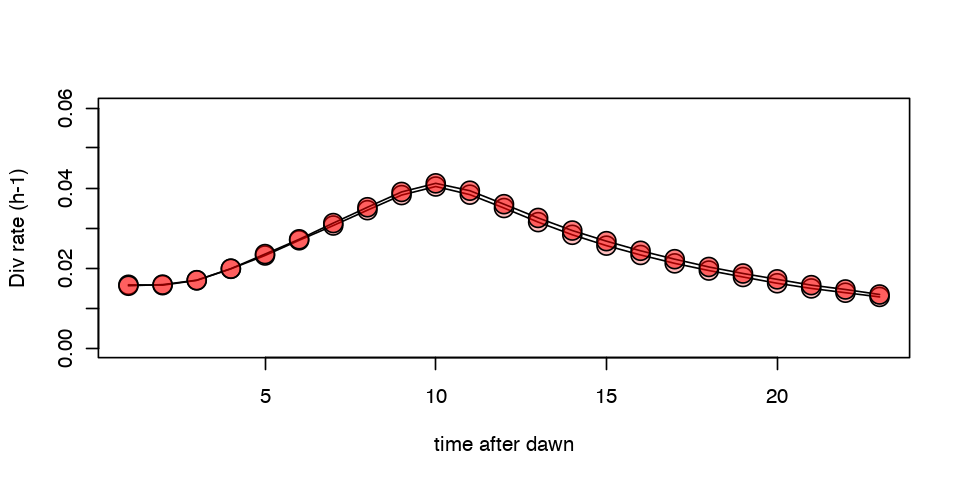

In [25]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N3[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

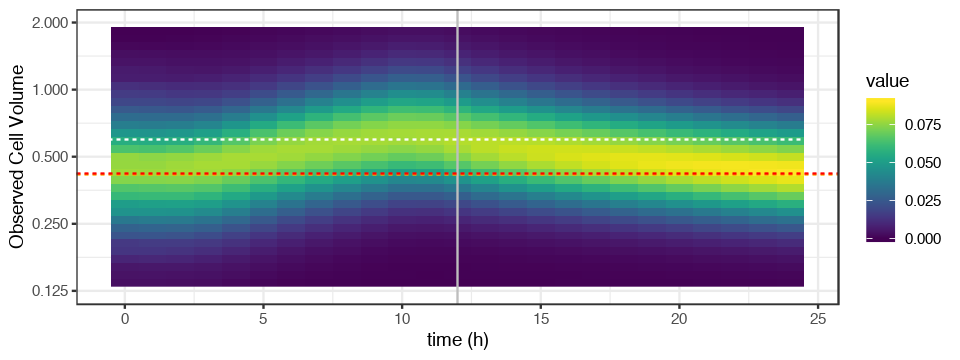

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

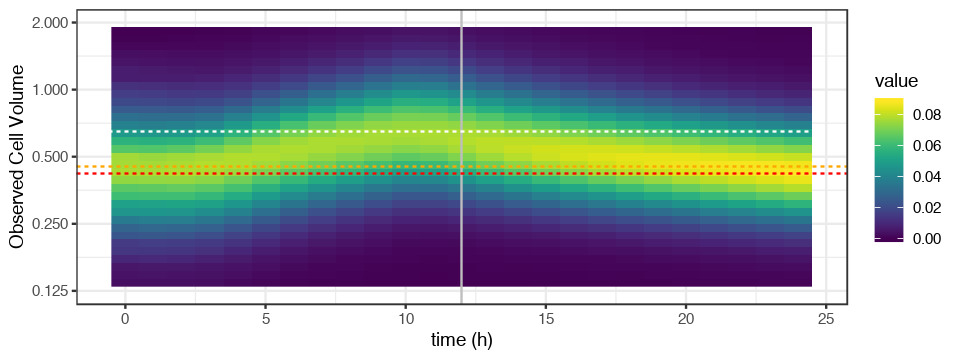

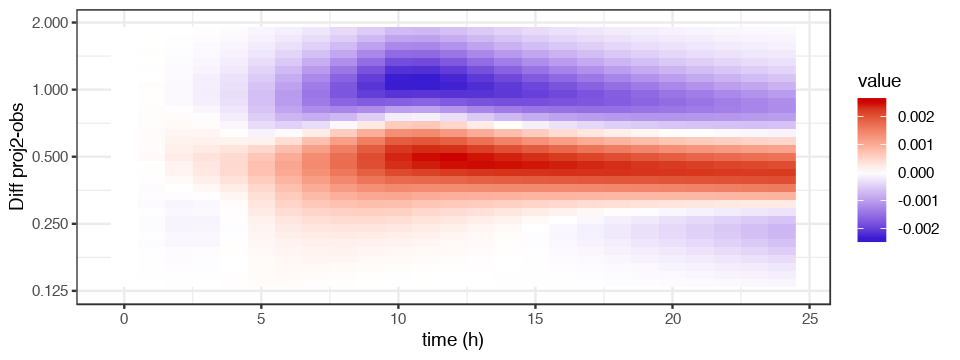

In [26]:
options(repr.plot.width=8, repr.plot.height=3)
i <- which(Vproj3[,12] == max(Vproj3[,12]))
f <- which(Vproj3[,24] == max(Vproj3[,24]))
ggplot(melt(Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + 
    scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

i <- which(Vproj3.[,12] == max(Vproj3.[,12]))
f <- which(Vproj3.[,24] == max(Vproj3.[,24]))
ggplot(melt(Vproj3.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + 
    scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj3-Vproj3.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj2-obs') + 
    scale_fill_gradient2(low='blue3',high='red3', midpoint=0)


# 4. Summary
---

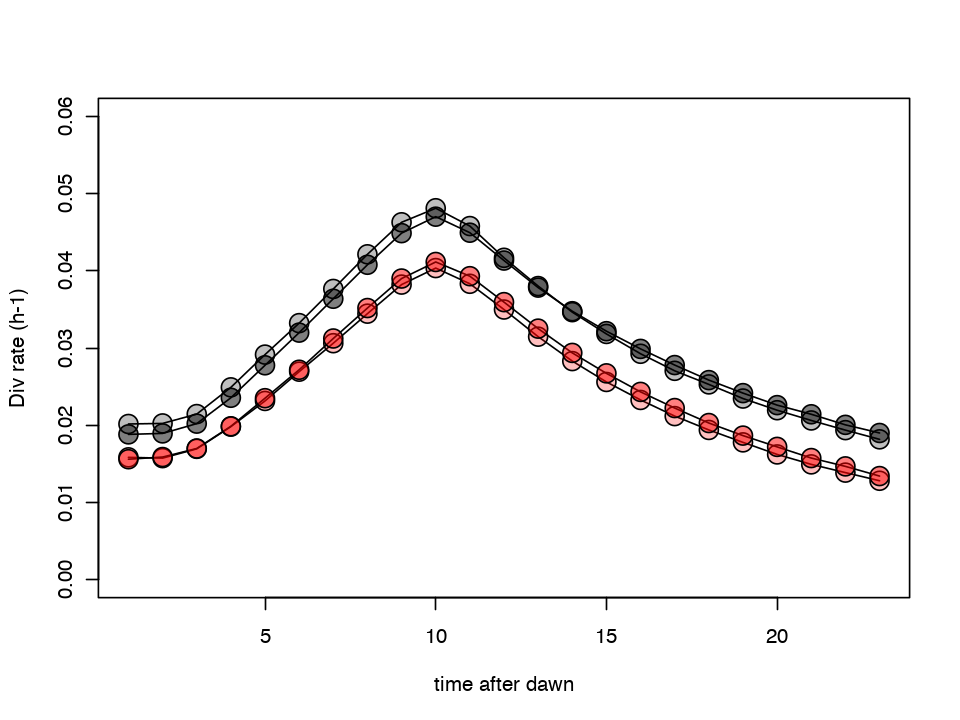

In [30]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

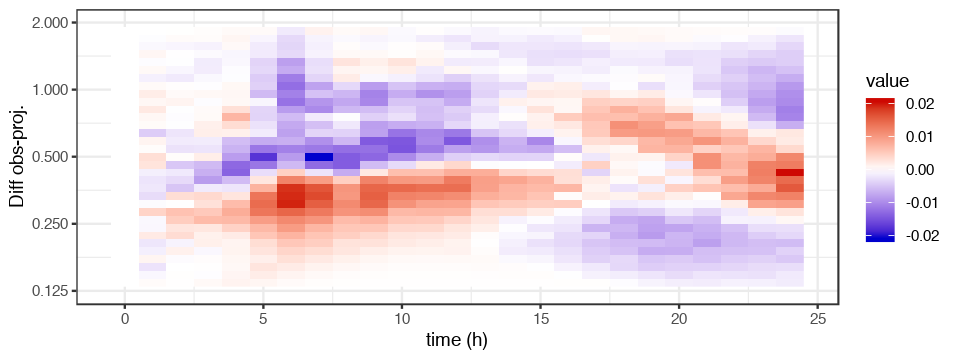

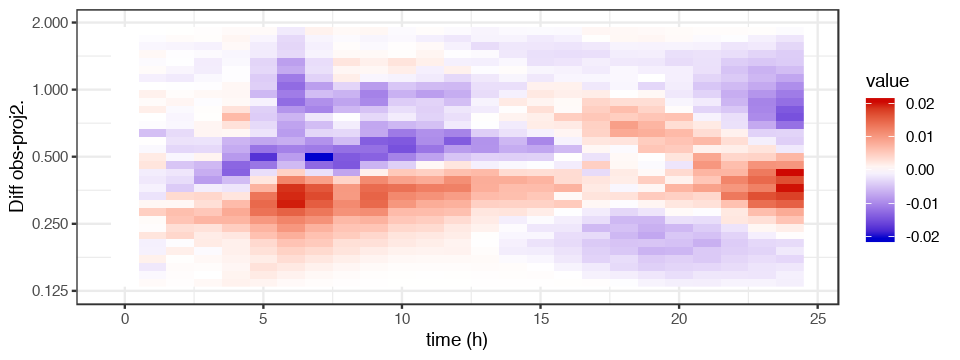

In [34]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj - V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj3 - V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj2.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

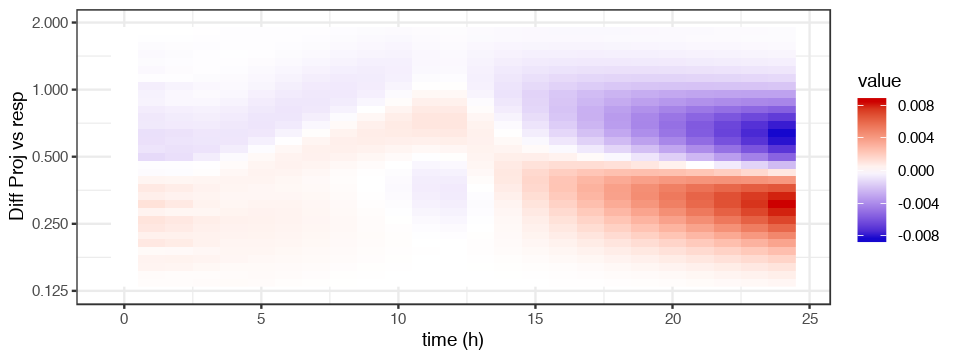

In [32]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj3. - Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff Proj vs resp') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)